# Automatic Differentiation from Scratch

## Introduction

Automatic differentiation refers to a family of numerical methods used to compute derivatives, gradients, and Jacobian matrices of numerical functions. These methods have the major advantage of eliminating a significant portion of rounding errors typically associated with classical methods such as finite differences. The error is in fact as low as in a "manual" symbolic differentiation of functions without the need for delicate parameter tuning.

In practice, if you were to implement manually the derivative of the function 
$$
f: x \in \R \mapsto \frac{1-e^{-2x}}{1+e^{-2x}} \in \R,
$$
you would probably start with the implementation of the function $f$, for example as:

In [1]:
def f(x):
    y = exp(-2.0 * x)
    u = 1.0 - y
    v = 1.0 + y
    w = u / v
    return w

and then proceed to implement its derivative $g:= f'$, typically as 

In [2]:
def g(x):
    y = exp(-2.0 * x)
    u = 1.0 - y
    v = 1.0 + y
    w = u / v
    dx = 1.0
    dy = -2.0 * exp(-2.0 * x) * dx
    du = 0.0 - dy
    dv = 0.0 + dy
    dw = du / v + u * (- dv) / (v * v)  
    return dw

Here, automatic differentiation would typically automate the generation of the function $g$ given the function $f$, giving you exactly the same results but avoiding all the tedious work (and the corresponding risks of manual computation errors).

## Computation Graph

Python being dynamically typed does not assign types to function arguments during their definition. Thus, the addition function,

In [3]:
def add(x, y):
    return x + y

allows of course adding floating-point numbers:

In [4]:
add(1.0, 2.0)

3.0

but it will also work perfectly fine with integers or NumPy arrays or even non-numeric types like strings:

In [5]:
add(1, 2)

3

In [6]:
add("one", "two")

'onetwo'

The key is that during execution, the objects `x` and `y` support the addition operation — otherwise, an exception will be raised. Thus, our add function is implicitly defined for addable objects.

This is also confirmed by examining the bytecode of the add function, which makes no reference to the type of the arguments `x` and `y`:

In [7]:
from dis import dis
dis(add)

  1           0 RESUME                   0

  2           2 LOAD_FAST                0 (x)
              4 LOAD_FAST                1 (y)
              6 BINARY_OP                0 (+)
             10 RETURN_VALUE


In the case of addition, the operation `x + y` is delegated to the `__add__` method of the `x` object. To intercept this call, it is necessary to modify the type of floating-point numbers we are going to use and override the definition of this method:

In [8]:
class Float(float):
    def __add__(self, other):
        print(f"trace: {self} + {other}")
        return super().__add__(other)

As our class inherits from the standard type float, operations we haven't explicitly redefined will be handled as usual. So, we've just modified addition for instances of `Float`, and in a very limited way since we've delegated the result calculation to the parent class float.

Once this effort is made, we can indeed trace the additions made:

In [9]:
x = Float(2.0) + 1.0
x

trace: 2.0 + 1.0


3.0

provided, of course, that we work with instances of `Float` and not `float`! 
To start generalizing this usage, 
we will ensure that operations on our floats return our own float type as much as possible:

In [10]:
class Float(float):
    def __add__(self, other):
        print(f"trace: {self} + {other}")
        return Float(super().__add__(other))

But this is not enough: Python's math library functions will return regular floats, 
so we need to adapt them again; first, let's import the math module:

In [11]:
import math

then define our own `cos` function:

In [12]:
def cos(x):
    print(f"trace: cos({x})")
    return Float(math.cos(x))

Let's check the result:

In [13]:
from math import pi
cos(pi) + 1.0

trace: cos(3.141592653589793)
trace: -1.0 + 1.0


0.0

Unfortunately, we still cannot correctly trace the very similar expression `1.0 + cos(pi)`:

In [14]:
1.0 + cos(pi)

trace: cos(3.141592653589793)


0.0

Indeed, it is the `__add__` method of `1.0`, an instance of `float`, that is called; thus, this call is not traced. 
To successfully handle this type of call, we need to ... make it fail! 
The method called to perform the sum so far entrusts the operation to the `__add__` method of 1.0 
because this object knows how to handle the operation, as it's 
about adding itself with another instance (deriving) of float.

If we ensure that the left operand is unable to handle this operation, it will be delegated to the right operand and the `__radd__` method; for this purpose, we simply replace `Float`, a numeric type, with `Node`, a class that contains (encapsulates) a numerical value:


In [15]:
class Node:
    def __init__(self, value):
        self.value = value

We won't dwell on this first version of `Node`. It's named like that because it will represent a node in a computation graph. Instead of displaying the operations performed on the standard output, we will record the operations each variable undergoes and how they are organized; each node resulting from an operation must remember which operation was applied and what the operation's arguments were (themselves nodes). To support this approach, `Node` becomes:

In [16]:
class Node:
    def __init__(self, value, function=None, *args):
        self.value = value
        self.function = function
        self.args = args

We then need to make the usual operations compatible with node creation; 
by examining the function's arguments, we must decide if it's in "normal" mode 
(receiving numerical values, producing numerical values) or tracing calculations. 
For example:

In [17]:
def cos(x):
    if isinstance(x, Node):
        cos_x_value = math.cos(x.value)
        cos_x = Node(cos_x_value, cos, x)
        return cos_x
    else:
        return math.cos(x) 

or

In [18]:
def add(x, y):
    if isinstance(x, Node) or isinstance(y, Node):
        if not isinstance(x, Node):
            x = Node(x)
        if not isinstance(y, Node):
            y = Node(y)
        add_x_y_value = x.value + y.value
        return Node(add_x_y_value, add, x, y)
    else:
        return x + y

The add function probably won't be used directly but called using the + operator; 
therefore, it must allow us to define the `__add__` and `__radd__` methods:

In [19]:
Node.__add__ = add
Node.__radd__ = add

We notice many similarities between the two codes; 
rather than continuing this process for all the functions we will need, 
at the expense of abstraction effort, 
it would be possible to define a function that automatically performs this transformation. 
This function is a higher-order function because it takes a function (the original numerical function) 
as an argument and returns a new function compatible with node management. 
We can ignore its implementation on first reading.

In [20]:
def autodiff(function):
    def autodiff_function(*args):
        if any([isinstance(arg, Node) for arg in args]):
            node_args = []
            values = []
            for arg in args:
                if isinstance(arg, Node):
                    node_args.append(arg)
                    values.append(arg.value)
                else:
                    node_args.append(Node(arg)) 
                    values.append(arg)
            output_value = function(*values)
            output_node = Node(
               output_value, autodiff_function, *node_args
            )
            return output_node
        else:
            return function(*args)        
    autodiff_function.__qualname__ = function.__qualname__
    return autodiff_function

Despite its apparent complexity, using this function is simple; 
thus, to make the `sin` function and the `*` operator compatible with node management, 
all we need to do is:

In [21]:
sin = autodiff(math.sin)

and

In [22]:
def multiply(x, y):
    return x * y
multiply = autodiff(multiply)
Node.__mul__ = Node.__rmul__ = multiply

which is considerably faster and more readable than the approach taken for `cos` and `+`; 
but once again, the result is the same.

It's now possible to implement the tracer. 
This function encapsulates the arguments of the function to trace into nodes, 
then calls the function and returns the node associated with the value returned by the function:

In [23]:
def trace(f, args):
    args = [Node(arg) for arg in args]
    end_node = f(*args)
    return end_node

To verify that everything is working as expected, let's ensure we display a readable and friendly representation of the node contents as a string:

In [24]:
def node_str(node):
    if node.function is None:
        return str(node.value)
    else:
        function_name = node.function.__qualname__
        args_str = ", ".join(str(arg) for arg in node.args)
        return f"{function_name}({args_str})"

Then, let's make sure it's used when invoking the `print` function, rather than the standard display:

In [25]:
Node.__str__ = node_str

We complete this description with a second representation, more explicit but also more verbose:

In [26]:
def node_repr(node):
    reprs = [repr(node.value)]
    if node.function is not None:
        reprs.append(node.function.__qualname__)
    if node.args:
        reprs.extend([repr(arg) for arg in node.args])
    args_repr = ", ".join(reprs)
    return f"Node({args_repr})"
Node.__repr__ = node_repr

We're ready to do our verification:

In [27]:
def f(x):
    return 1.0 + cos(x)

end = trace(f, [pi])
end

Node(0.0, add, Node(-1.0, cos, Node(3.141592653589793)), Node(1.0))

In [28]:
print(end)

add(cos(3.141592653589793), 1.0)


The result is read as follows: the calculation of `f(pi)` produces the value `0.0`, 
resulting from the addition of `-1.0`, calculated as `cos(3.141592653589793)`, 
and the constant `1.0`. So, this seems correct!

Another example, with two arguments, just for good measure:

In [29]:
def f(x, y):
    return x * (x + y)

t = trace(f, [1.0, 2.0])
t

Node(3.0, multiply, Node(1.0), Node(3.0, add, Node(1.0), Node(2.0)))

In [30]:
print(t)

multiply(1.0, add(1.0, 2.0))


## Visualization

In [31]:
import graphviz  

def graph(end_node):
    dot = graphviz.Digraph()
    todo = [end_node]
    while todo:
        node = todo.pop()
        id_ = str(id(node))
        label = node.function.__qualname__ if node.function else str(node.value) 
        dot.node(id_, label)
        for arg in node.args:
            dot.node(str(id(arg)), node.function.__qualname__ or str(node.value))
            dot.edge(id_, str(id(arg)))
        todo.extend(node.args)
    return dot

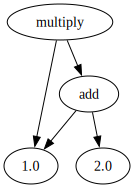

In [32]:
graph(t)

In [33]:
def graph_function(f, *args):
    start_nodes = [Node(arg) for arg in args]
    end_node = f(*start_nodes)
    return graph(end_node)

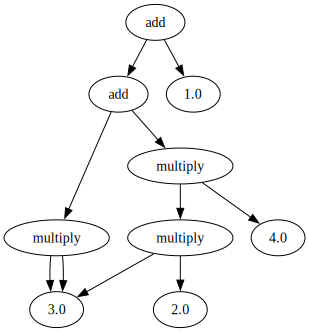

In [34]:
def f(x, y):
    return x * x + 2.0 * x * y + 1.0

graph_function(f, 3.0, 4.0)

## Differential of Elementary Functions

To leverage the computation graph we can now determine, we need to declare the differentials 
of primitive operations and functions in a "registry" of differentials, 
indexed by the function to differentiate.

In [35]:
differential = {}

For addition and multiplication, we utilize the identities $d(x+y) = dx + dy$ and $d(x \times y) = x \times dy + dx \times y$:

In [36]:
def d_add(x, y):
    return add

differential[add] = d_add

def d_multiply(x, y):
    def d_multiply_xy(dx, dy):
        return x * dy + dx * y
    return d_multiply_xy

differential[multiply] = d_multiply

For a function such as `cos`, we use the identity $d (\cos(x)) = -\sin(x) dx$:

In [37]:
def d_cos(x):
    def d_cos_x(dx):
        return - sin(x) * dx
    return d_cos_x

differential[cos] = d_cos

But this is just a particular case of the identity $d (f(x)) = f'(x) dx$. 
We can equip ourselves with a function that will compute the differential $df$ from the derivative $f'$:

In [38]:
def d_from_deriv(g):
    def d_f(x):
        def d_f_x(dx):
            return g(x) * dx
        return d_f_x
    return d_f

The declaration of differentials is thus simplified; for instance, from the identity $(\sin x)' = \cos x$, we have:

In [39]:
differential[sin] = d_from_deriv(cos)

## Differential of Composite Functions

To leverage the tracing of a function, we need to extract from the final node produced by this process all the upstream nodes, which represent the arguments used in the calculation of the final value. Then, to prepare for the calculation of the differential, we will order the nodes so that the arguments of a function always appear before the value it produces. The following implementation, relatively naive, accomplishes this operation:

In [40]:
def find_and_sort_nodes(end_node):
    todo = [end_node]
    nodes = []
    while todo:
        node = todo.pop()
        nodes.append(node)
        for parent in node.args:
            if parent not in nodes + todo:
                todo.append(parent) 
    done = []
    while nodes:
        for node in nodes[:]:
            if all([parent in done for parent in node.args]):
                done.append(node)
                nodes.remove(node)
    return done

The calculation of the differential itself then consists of propagating the variation of the node arguments 
from node to node, based on the chain rule of differentiation; 
these intermediate variations are stored in the `d_value` attribute of the graph nodes.

In [41]:
def d(f):
    def df(*args): # args=(x1, x2, ...)
        start_nodes = [Node(arg) for arg in args]
        end_node = f(*start_nodes)
        if not isinstance(end_node, Node): # constant value
            end_node = Node(end_node)
        nodes = find_and_sort_nodes(end_node).copy()
        def df_x(*d_args): # d_args = (d_x1, d_x2, ...)
            for node in nodes:
                if node in start_nodes:
                    i = start_nodes.index(node)
                    node.d_value = d_args[i]
                elif node.function is None: # constant node
                    node.d_value = 0.0
                else:
                    _d_f = differential[node.function]
                    _args = node.args
                    _args_values = [_node.value for _node in _args]
                    _d_args = [_node.d_value for _node in _args]
                    node.d_value = _d_f(*_args_values)(*_d_args)
            return end_node.d_value
        return df_x
    return df

## Usage

To simply leverage our differential calculation, we can deduce the derivative in the case of a function of a real variable; recall that we have $f'(x) = df(x) \cdot 1$.

In [42]:
def deriv(f):
    df = d(f)
    def deriv_f(x):
        return df(x)(1.0)
    return deriv_f

Let's verify that the behavior of these differentiation operators meets our expectations for single-variable functions; first, in the case of a constant function:

In [43]:
def f(x):
    return pi

g = deriv(f)

In [44]:
g(0.0)

0.0

In [45]:
g(1.0)

0.0

In [46]:
g(2.0)

0.0

Then, in the case of an affine function:

In [47]:
def f(x):
    return 2.0 * x + 1.0

g = deriv(f)

In [48]:
g(0.0)

2.0

In [49]:
g(1.0)

2.0

In [50]:
g(2.0)

2.0

And finally, in the case of a quadratic function:

In [51]:
def f(x):
    return x * x + 2 * x + 1

g = deriv(f)

In [52]:
g(0.0)

2.0

In [53]:
g(1.0)

4.0

In [54]:
g(2.0)

6.0

To conclude within this framework, 
let's test two functions using trigonometric functions `sin` and `cos`:

In [55]:
def f(x):
    return cos(x) * cos(x) + sin(x) * sin(x)

g = deriv(f)

In [56]:
g(0.0)

0.0

In [57]:
g(1.0)

0.0

In [58]:
g(2.0)

0.0

In the general case, since our functions always yield real values, we can deduce the gradient of the differential:

In [59]:
def grad(f):
    df = d(f)
    def grad_f(*args):
        n = len(args)
        grad_f_x = n * [0.0]
        df_x = df(*args)
        for i in range(0, n):
            e_i = n * [0.0]; e_i[i] = 1.0
            grad_f_x[i] = df_x(*e_i)
        return grad_f_x  
    return grad_f

Similarly, constant, affine, and quadratic functions allow for elementary tests:

In [60]:
def f(x, y):
    return 1.0

In [61]:
grad(f)(0.0, 0.0)

[0.0, 0.0]

In [62]:
grad(f)(1.0, 2.0)

[0.0, 0.0]

In [63]:
def f(x, y):
    return x + 2.0 * y + 1.0

In [64]:
grad(f)(0.0, 0.0)

[1.0, 2.0]

In [65]:
grad(f)(1.0, 2.0)

[1.0, 2.0]

In [66]:
def f(x, y):
    return x * x + y * y

In [67]:
grad(f)(0.0, 0.0)

[0.0, 0.0]

In [68]:
grad(f)(1.0, 2.0)

[2.0, 4.0]

## Backward Differentiation

In [69]:
gradient = {}

In [70]:
def grad_sin(x):
    return [cos(x)]

gradient[sin] = grad_sin

def grad_cos(x):
    return [-sin(x)]

gradient[cos] = grad_cos

def grad_add(x, y):
    return [1.0, 1.0]

gradient[add] = grad_add

def grad_multiply(x, y):
    return [y, x]

gradient[multiply] = grad_multiply

In [71]:
def backward_grad(f):
    def grad_f(*args): # args=(x1, x2, ...)
        start_nodes = [Node(arg) for arg in args]
        end_node = f(*start_nodes)
        if not isinstance(end_node, Node): # constant value
            end_node = Node(end_node)
        nodes = find_and_sort_nodes(end_node)
        nodes.reverse()
        end_node_args_values = [arg.value for arg in end_node.args] 
        end_node.grad = gradient[end_node.function](*end_node_args_values)

        for node in nodes:
            if node.function is not None:
                assert len(node.grad) == len(node.args)
                for i, node_i in enumerate(node.args):
                    g_i = node.grad[i]
                    if not hasattr(node_i, "grad"):
                        node_i.grad = max(1, len(node_i.args)) * [0.0]
                    if node_i.function is None:
                        gradient_ = [1.0]
                    else:
                        node_args_values = [arg.value for arg in node_i.args] 
                        gradient_ = gradient[node_i.function](*node_args_values)
                    extra_grad = [g_i * g for g in gradient_]
                    node_i.grad = [g + xg for g, xg in zip(node_i.grad, extra_grad)]
        return [node.grad[0] for node in start_nodes]
    return grad_f

In [72]:
def f(x):
    return 0.0 * x * x
g = backward_grad(f)

In [73]:
g(1.0)

[0.0]

In [74]:
g(2.0)

[0.0]

In [75]:
def f(x, y):
    return x * x + 2.0 * x * y + 3.0 * y * y + 1.0

g = backward_grad(f)

In [76]:
g(0.0, 0.0)

[0.0, 0.0]

In [77]:
g(1.0, 0.0)

[2.0, 2.0]

In [78]:
g(0.0, 1.0)

[2.0, 6.0]

In [79]:
g(2.0, 3.0)

[10.0, 22.0]